In [6]:
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml

sns.set_theme()
sns.set_context("paper")

In [7]:
fig_dir = Path.home() / "dev/data/exp/follow/figures"
fig_dir.mkdir(parents=True, exist_ok=True)

RHCR_dir = Path.home() / "dev/data/exp/RHCR"

exp_runs = glob.glob("2024-12-03*/", root_dir=RHCR_dir)

data_dirs = [RHCR_dir / run for run in exp_runs]

In [8]:
def read_yaml(file_path):
    with open(file_path, mode="r") as file:
        data = yaml.safe_load(file)
    return data


configs = [read_yaml(data_dir / "config.yaml") for data_dir in data_dirs]
for i in range(1, len(configs)):
    assert configs[i]["git_hash"] == configs[i - 1]["git_hash"]

df = pd.concat(
    [pd.read_csv(data_dir / "result.csv") for data_dir in data_dirs], ignore_index=True
)

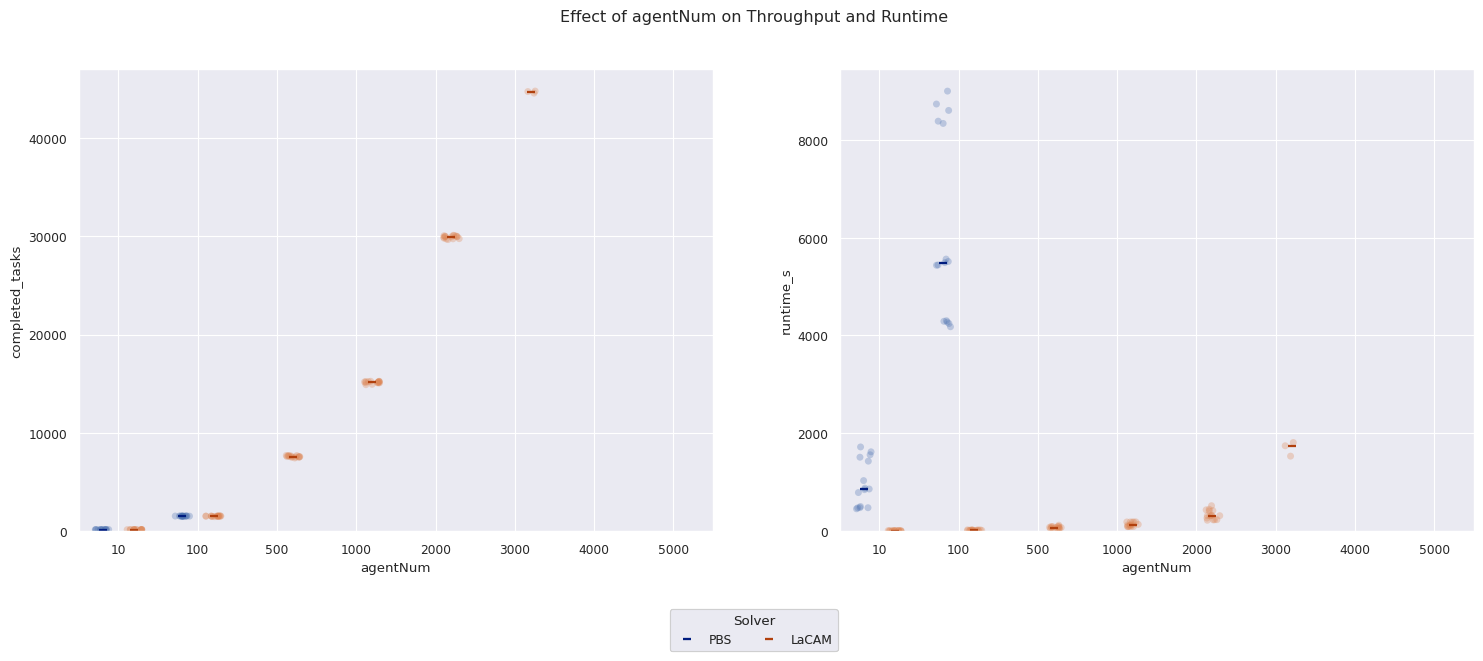

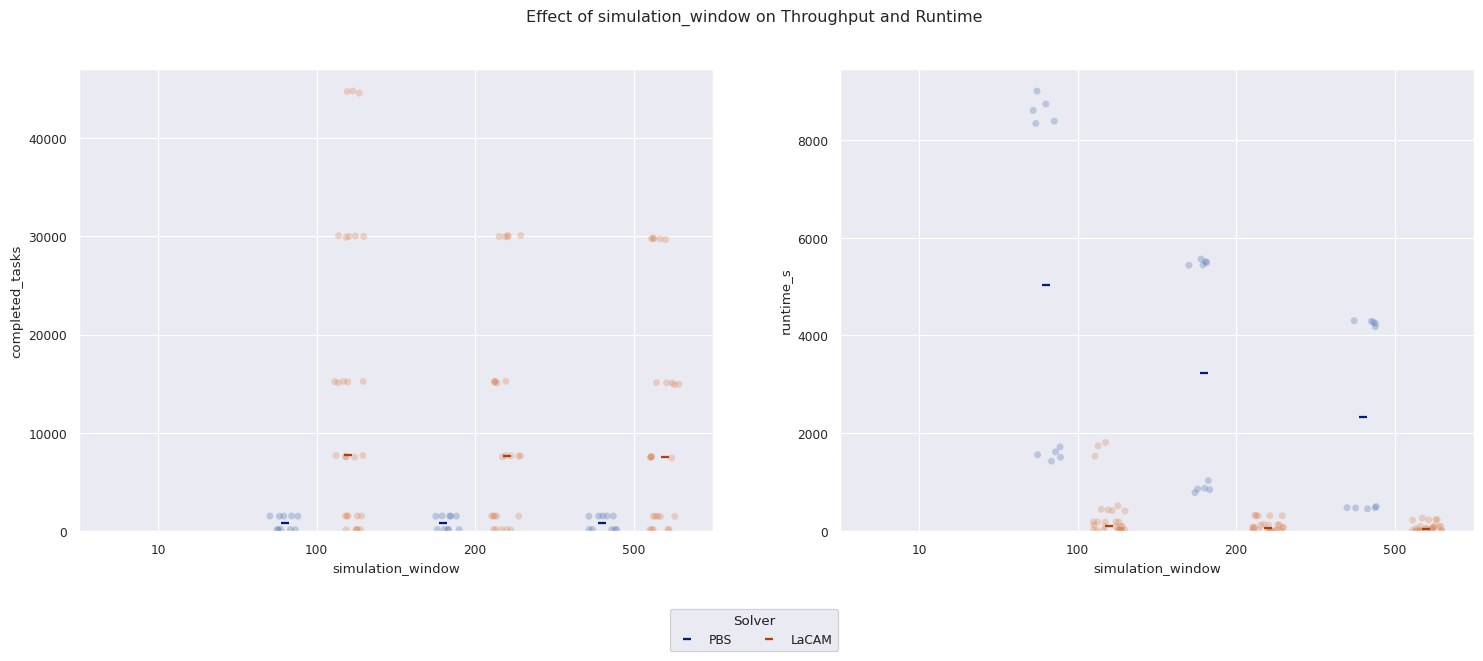

In [9]:
x_vars = [
    "agentNum",
    "simulation_window", 
    # "planning_window", 
]
for x_var in x_vars:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f'Effect of {x_var} on Throughput and Runtime')
    fig.set_size_inches(18, 6)

    y_vars = ["completed_tasks", "runtime_s"]
    for i, y_var in enumerate(y_vars):
        ax = axs[i]
        melted = df.melt(
            id_vars=["solver", x_var], var_name="measurement", value_vars=[y_var]
        )

        # sns.despine(left=False, bottom=False)
        ax = sns.stripplot(
            data=melted,
            x=x_var,
            y="value",
            hue="solver",
            dodge=True,
            alpha=0.3,
            jitter=0.2,
            ax=ax,
            legend=False,
            zorder=1,
        )

        ax = sns.pointplot(
            data=melted,
            x=x_var,
            y="value",
            hue="solver",
            dodge=0.8 - 0.8 / len(melted["solver"].unique()),
            palette="dark",
            errorbar=None,
            markers="_",
            # markersize=10,
            linestyle="none",
            ax=ax,
            legend=True,
            estimator="median",
        )

        ax.set_ylim(bottom=0)
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)

        if (legend := ax.get_legend()) is not None:
            legend.remove()
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        fig.legend(
            legend_handles,
            legend_labels,
            loc = "lower center",
            bbox_to_anchor=(0.5, -0.1),
            ncol=len(melted["solver"].unique()),
            frameon=True,
            title="Solver",
        )
        ax.grid(True)
